# Testing and examples of band structure calculation
## Single-layer graphene $\pi$ bands beyond the Dirac cone approximation and taking into account overlap

## Import modules

In [1]:
import sys 
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import interactive

sys.path.insert(0, '..')

from pybandstructure import *

import graphene as gr

## Example parameters for graphene full BZ

In [2]:
#################### graphene parameters ###############################
#distances in nm, energies in eV
a0 = .142  #graphene carbon-carbon distance
t = -3.28    # nearest neighbour hopping
s = 0.129    # nearest neighbour overlap
ep = -4.5  # energy of carbon p_z orbital
hv = 1.5 * abs(t) * a0 #\hbar v_D
################### Computational parameters ###########################
n_sites = 240 # number of lattice sites in each direction, can be int or
#tuple of int. If symmetry is used it must be int and n_sites % 6 == 0.
eta = 3 * 2. * np.pi * abs(t) / n_sites  #energy smoothing in eV
########################################################################
######### Density and temerature (can be changed dynamically) ##########
density = 0. #in nm^-2 = 10^14 cm^-2
temperature = 0.026 #k_B T in eV. Room Temperature = 0.026

## Crystal geometry and sampling

In [3]:
#primitive vectors of the direct lattice
translation_vectors = np.sqrt(3) * a0 * np.array([[0.5 * np.sqrt(3), 0.5 * np.sqrt(3)],
                                                  [             0.5,             -0.5]])
#angle of the first principal axis
theta0 = np.arctan2(translation_vectors[1,0], translation_vectors[0,0])
point_group = Point_Group.dihedral_group(n=6, theta0 = theta0)

#defines lattice geometry given Bravais lattice and point group
lattice_geometry = Crystal_Geometry(translation_vectors = translation_vectors, point_group = point_group)

#defines sampling of the irreducible Brillouin zone
k_sample = Unit_Cell_Sample.irreducible_sample(name = '2D_Hexagonal_D6',
                                               basis_vectors = lattice_geometry.reciprocal_lattice_basis, 
                                               denominator = n_sites)

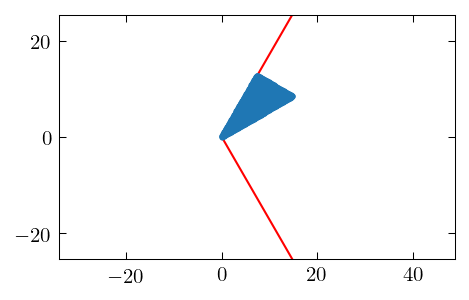

In [4]:
if True:
    k_sample.plot()


## Graphene single-layer hamiltonian
We want to solve the generalized eigenvalue problem
$$ {\cal H} ({\bf k}) u_\nu({\bf k}) = \epsilon_\nu({\bf k}) {\cal S}({\bf k}) u_\nu({\bf k})$$
where the hamiltonian matrix is given by
$$ {\cal H} ({\bf k}) = \begin{bmatrix}E_p & tf({\bf k}) \\ tf^*({\bf k}) & E_p\end{bmatrix} = E_p {\bf 1} + t\Re f({\bf k}) \sigma_x -t\Im f({\bf k}) \sigma_y$$
the overlap matrix is
$$ {\cal S} ({\bf k}) = \begin{bmatrix}1 & sf({\bf k}) \\ sf^*({\bf k}) & 1\end{bmatrix} = {\bf 1} + s\Re f({\bf k}) \sigma_x -s\Im f({\bf k}) \sigma_y$$
and 
$$ f({\bf k}) = e^{i {\bf k} \cdot {\bf \delta}_1} + e^{i {\bf k} \cdot {\bf \delta}_2} + e^{i {\bf k} \cdot {\bf \delta}_3}$$

## Alternative implementation using vector functions

In the above example used the $\sigma_x$ $\sigma_y$ basis.
The basis $\sigma^{\pm}=1/2(\sigma_x \pm i \sigma_y)$ would have worked as well.
Here we show an alternative implementation using vector functions. An element of hamiltonian_functions can be a function returning a vector or a vector of constants. In this case the corresponding element of hamiltonian_matrices should be a list of matrices with the corresponding length

In [5]:
#################### Hamiltonian and overlap matrices ##########################
class f_graphene:
    def __init__(self, a0, der = (0,0)):
        self.a0 = a0
        self.der = der
    def __call__(self, k):
        if self.der == (0,0):
            return (np.exp(1j * k[0] * self.a0) 
                    + 2 * np.exp(-1j * k[0] * self.a0/2) * np.cos(np.sqrt(3)/2 * self.a0 * k[1]))
        elif self.der == (1,0):
            return (1.j * self.a0 * np.exp(1j * k[0] * self.a0) 
                    - 1.j * self.a0 * np.exp(-1j * k[0] * self.a0/2) * np.cos(np.sqrt(3)/2 * self.a0 * k[1]))
        elif self.der == (0,1):
            return (- np.sqrt(3) * self.a0 * np.exp(-1j * k[0] * self.a0/2) * np.sin(np.sqrt(3)/2 * self.a0 * k[1]))
        else:
            raise ValueError('Only first derivatives implemented')

class abs_f_2:
    def __init__(self, a0, der = (0,0)):
        self.a0 = a0
        self.der = der
    def __call__(self, k):
        if self.der == (0,0):
            return (1 
                    + 4 * (np.cos(0.5 * np.sqrt(3) * self.a0 * k[1]))**2 
                    + 4 * np.cos(0.5 * self.a0 * k[0]) * np.cos(0.5 * np.sqrt(3) * self.a0 * k[1]))
        elif self.der == (1,0):
            return -2* self.a0 * np.sin(0.5 * self.a0 * k[0]) * np.cos(0.5 * np.sqrt(3) * self.a0 * k[1])
        elif self.der == (0,1):
            return -2* np.sqrt(3) * self.a0 * np.sin(0.5 * np.sqrt(3) * self.a0 * k[1]) *(np.cos(0.5 * self.a0 * k[0]) + 2 * np.cos(0.5 * np.sqrt(3) * self.a0 * k[1]))
        else:
            raise ValueError('Only first derivatives implemented')

f = f_graphene(a0 = a0)
f_x = f_graphene(a0 = a0, der = (1,0))
f_y = f_graphene(a0 = a0, der = (0,1))
g_x = abs_f_2(a0 = a0, der = (1,0))
g_y = abs_f_2(a0 = a0, der = (0,1))


hamiltonian_matrices = [[ pauli_matrix('+'),  pauli_matrix('-')],  pauli_matrix('I')]
hamiltonian_coefficients = [lambda k:  [t * f(k), t * np.conj(f(k))],  ep]
overlap_matrices = [[ pauli_matrix('+'),  pauli_matrix('-')],  pauli_matrix('I')]
overlap_coefficients = [lambda k: [ s * f(k),  s * np.conj(f(k))],  1.]
    
H = Momentum_Conserving_Operator(matrices = hamiltonian_matrices,
                                 coefficients = hamiltonian_coefficients) 
S = Momentum_Conserving_Operator(matrices = overlap_matrices,
                                 coefficients = overlap_coefficients)

p0_x = Momentum_Conserving_Operator(matrices = [[ pauli_matrix('+'),  pauli_matrix('-')]],
                                 coefficients = [lambda k:  [t * f_x(k), t * np.conj(f_x(k))]])
p0_y = Momentum_Conserving_Operator(matrices = [[ pauli_matrix('+'),  pauli_matrix('-')]],
                                 coefficients = [lambda k:  [t * f_y(k), t * np.conj(f_y(k))]])
m_x = Momentum_Conserving_Operator(matrices = [pauli_matrix('I'), pauli_matrix('+'),  pauli_matrix('-')],
                                   coefficients = [lambda k: 0.5 * t * s * g_x(k),
                                                   lambda k: ep * s * f_x(k),
                                                   lambda k: ep * s * np.conj(f_x(k))])
m_y = Momentum_Conserving_Operator(matrices = [pauli_matrix('I'), pauli_matrix('+'),  pauli_matrix('-')],
                                   coefficients = [lambda k: 0.5 * t * s * g_y(k),
                                                   lambda k: ep * s * f_y(k),
                                                   lambda k: ep * s * np.conj(f_y(k))])
p_x = p0_x - m_x
p_y = p0_y - m_y #careful, this must be checked again

# Calculate energy bands, momentum matrix and initialize graphene

In [6]:
####################### Output folder ##################################
output_folder = 'test_output/single_layer'
file_name = '/single_layer.hdf5'
########################################################################
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
try:
    os.remove(output_folder + file_name)
except:
    pass

band_structure = Band_Structure.from_hamiltonian(k_sample = k_sample,
                                                 hamiltonian = H,
                                                 overlap = S, 
                                                 momentum_operator= [p_x,p_y],
                                                 degeneracy = 2,
                                                 zero_filling = 1,
                                                 density = density,
                                                 temperature = temperature)

band_structure.compute_bands()
band_structure.compute_momentum_matrix()
band_structure.save(file_name = output_folder + file_name, band_structure_name = 'band_structure')
graphene = Crystal(geometry = lattice_geometry,
                   band_structure = band_structure, 
                   eta = eta)


100%|████████████████████████████████████████████████████████████████████████████| 4921/4921 [00:01<00:00, 2564.36it/s]


# Make a colorplot of one band in the Brillouin zone

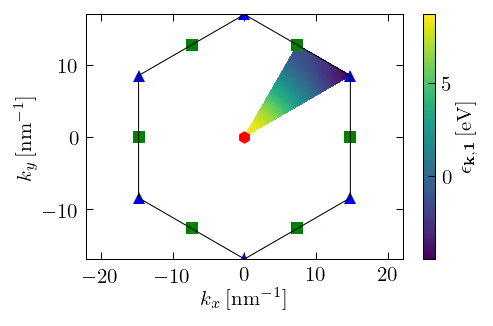

In [7]:
if True:
    nu= 1
    ########################################################################
    G = lin.norm(lattice_geometry.reciprocal_lattice_basis[:,0])

   
    plt.figure()
    plt.axes()
    plt.axis('equal')
    plt.xlabel(r'$k_x\,[{\rm nm^{-1}}]$')
    plt.ylabel(r'$k_y\,[{\rm nm^{-1}}]$')
    plt.xlim(-G/2,G/2)
    plt.ylim(-np.sqrt(3)*G/3,np.sqrt(3)*G/3)

    #M-points
    plt.plot(G/2,0,'gs',ms=6)
    plt.plot(-G/2,0,'gs',ms=6)
    plt.plot(G/4,G*np.sqrt(3)/4,'gs',ms=6)
    plt.plot(-G/4,G*np.sqrt(3)/4,'gs',ms=6)
    plt.plot(G/4,-G*np.sqrt(3)/4,'gs',ms=6)
    plt.plot(-G/4,-G*np.sqrt(3)/4,'gs',ms=6)

    #Gamma-points
    plt.plot(0,0,'rh',ms=6)

    #K-points
    plt.plot(0,G/np.sqrt(3),'b^',ms=6)
    plt.plot(G/2,G/(2 *np.sqrt(3)),'b^',ms=6)
    plt.plot(G/2,-G/(2 *np.sqrt(3)),'b^',ms=6)
    plt.plot(0,-G/np.sqrt(3),'b^',ms=6)
    plt.plot(-G/2,-G/(2 *np.sqrt(3)),'b^',ms=6)
    plt.plot(-G/2,G/(2 *np.sqrt(3)),'b^',ms=6)

    plt.plot([0,G/2,G/2,0,-G/2,-G/2,0],
             [G/np.sqrt(3), G/(2 *np.sqrt(3)),-G/(2 *np.sqrt(3)),-G/np.sqrt(3),-G/(2 *np.sqrt(3)),G/(2 *np.sqrt(3)),G/np.sqrt(3)],
             c='k', lw=0.5)

    plt.tripcolor(graphene.band_structure.k_sample.coords[:,0],  
                  graphene.band_structure.k_sample.coords[:,1], 
                  graphene.band_structure.energies[nu,:])

    cb = plt.colorbar()
    cb.set_label(r'$\epsilon_{{\bf k,{}}}\,[{{\rm eV}}]$'.format(nu))
    plt.savefig(output_folder +'/single_band.pdf')

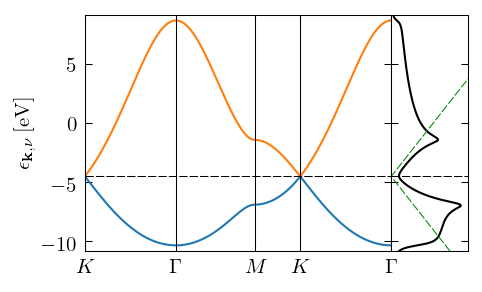

In [8]:
e_vals = np.linspace(np.amin(graphene.band_structure.energies)- 0.5, 
                     np.amax(graphene.band_structure.energies)+ 0.5,
                     num=250)
e_lims = e_vals[0], e_vals[-1] #energy limits for the figure
contour = [r'$K$', r'$\Gamma$', r'$M$', r'$K$',r'$\Gamma$']
dosvals = graphene.dos(e_vals) #total dos by summing over band-resolved dos
################################################################################
#figure
plt.figure()
plt.axes([0.2,0.2,0.6,0.75])

#band plot
graphene.band_structure.plot(contour,emin = e_lims[0],emax = e_lims[-1])

plt.ylabel(r'$\epsilon_{\bf k,\nu}\, [{\rm eV}]$')
#dos panel
ax = plt.axes([0.8,0.2,0.15,0.75])
ax.yaxis.set_label_position("right")
ax.set_xticks([])
ax.set_yticklabels([])
plt.ylim(e_lims[0],e_lims[-1])
plt.xlim(0,1.1*np.amax(dosvals))
plt.plot(dosvals ,e_vals, c='k')
plt.plot(2 * abs(e_vals- graphene.band_structure.chemical_potential)/(np.pi * hv**2),e_vals,'--', c='g', lw=0.5)
plt.plot([0,1.1*np.amax(dosvals)],[graphene.band_structure.chemical_potential,graphene.band_structure.chemical_potential],'--',c='k', lw=0.5)

plt.savefig(output_folder +'/SLbands.pdf')

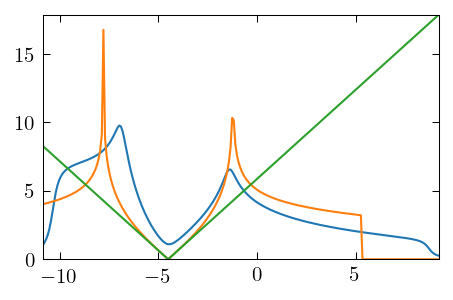

In [9]:
plt.plot(e_vals,dosvals)
plt.plot(e_vals, gr.dos_graphene(e_vals-ep, t = abs(t) ,a=a0))
plt.plot(e_vals, gr.dos_graphene_dirac(e_vals-ep, t = abs(t) ,a=a0))

## Calculate optical conductivity

In [10]:
omega_vals = np.linspace(0,10, num = 1000)
sigma_vals = graphene.local_conductivity(omega_vals)[:,0,0]

..\pybandstructure\crystal\analysis\conductivity_functions.py:8: RuntimeWarning: invalid value encountered in true_divide
  prefactor = -occupation_diff / energy_diff


## Plot

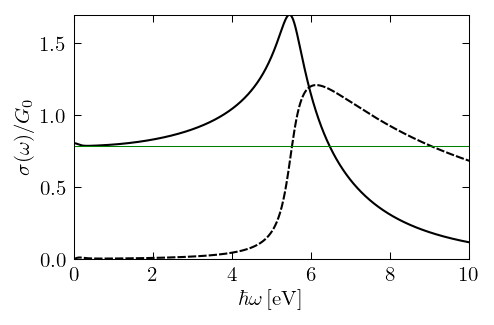

In [11]:
plt.xlabel(r'$\hbar \omega \, [{\rm eV}]$')
plt.ylabel(r'$\sigma(\omega)/G_0$')

plt.plot(omega_vals, np.real(sigma_vals), c='k')
plt.plot(omega_vals, np.imag(sigma_vals),'--',c='k')
plt.plot(omega_vals,np.ones_like(omega_vals)*np.pi/4,'-', c='g', lw=0.5)
plt.plot(omega_vals,np.zeros_like(omega_vals),'k-',lw=0.5)
plt.savefig(output_folder +'/conductivity.pdf')

## Dynamically change chemical potential

In [12]:
graphene.band_structure.chemical_potential = ep + 0.116
print(graphene.band_structure.density)

0.014849022585369662


..\pybandstructure\band_structure\band_structure.py:609: UserWarning: changing chemical potential 
                         without changing band structure
  without changing band structure"""


In [13]:
sigma_vals2 = graphene.local_conductivity(omega_vals)[:,0,0]

..\pybandstructure\crystal\analysis\conductivity_functions.py:8: RuntimeWarning: invalid value encountered in true_divide
  prefactor = -occupation_diff / energy_diff


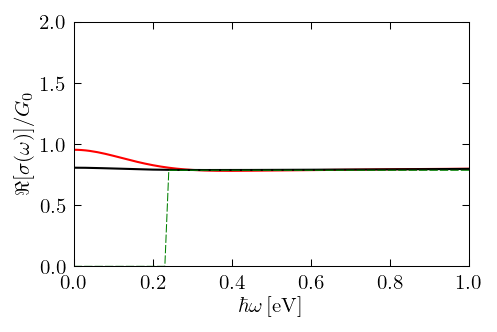

In [14]:
plt.xlabel(r'$\hbar \omega \, [{\rm eV}]$')
plt.ylabel(r'$\Re[\sigma(\omega)]/G_0$')

plt.plot(omega_vals, np.real(sigma_vals2),c='r')
plt.plot(omega_vals, np.real(sigma_vals),c='k')
plt.plot(omega_vals,np.heaviside(omega_vals-2*abs(graphene.band_structure.chemical_potential-ep),0.5)*np.pi/4,'--', c='g', lw=0.5)
plt.xlim(0,1)
plt.ylim(0, 2)
plt.savefig(output_folder +'/conductivity2.pdf')

C:\Users\Windows\Dropbox\ICFO\python_projects\bandstructure-calculation\notebooks\graphene.py:48: RuntimeWarning: divide by zero encountered in true_divide
  return 9.*np.pi**2*t**2*a**2/(32*omega)*dos_graphene(omega/2.,t,a)*(1.-0.5*(omega/(3*t))**2)*(np.tanh((omega+2*mu)/(4.*T))+np.tanh((omega-2*mu)/(4.*T)))
C:\Users\Windows\Dropbox\ICFO\python_projects\bandstructure-calculation\notebooks\graphene.py:48: RuntimeWarning: invalid value encountered in multiply
  return 9.*np.pi**2*t**2*a**2/(32*omega)*dos_graphene(omega/2.,t,a)*(1.-0.5*(omega/(3*t))**2)*(np.tanh((omega+2*mu)/(4.*T))+np.tanh((omega-2*mu)/(4.*T)))


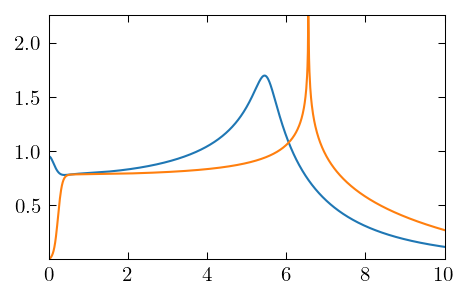

In [15]:
plt.plot(omega_vals,np.real(sigma_vals2))
plt.plot(omega_vals, gr.Re_sigma_interband_Stauber(omega_vals, 
                                                   mu = graphene.band_structure.chemical_potential-ep,
                                                   T = graphene.band_structure.temperature,
                                                  t=abs(t), a = a0))
